# Big Data and Cloud Computing - Final Project

## Data cleaning and exploratory analysis

### Author:
Alen Pavlovic

The University of Chicago

In [1]:
2*3-14

-8

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [3]:
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 20)

In [4]:
intermediate_bucket = 'gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project'
USE_DEV = True  # Use 10% sample for faster processing

In [5]:
def load_data(use_dev=True):
    """Load reviews and metadata"""
    if use_dev:
        reviews_df = spark.read.parquet(f"{intermediate_bucket}/reviews_dev")
        meta_df = spark.read.parquet(f"{intermediate_bucket}/meta_dev")
        print("Using 10% development dataset")
    else:
        reviews_df = spark.read.parquet(f"{intermediate_bucket}/reviews_processed")
        meta_df = spark.read.parquet(f"{intermediate_bucket}/meta_processed")
        print("Using full dataset")
    
    print(f"Reviews loaded: {reviews_df.count():,}")
    print(f"Products loaded: {meta_df.count():,}")
    
    # Show schema to understand variables
    print("\nReview schema:")
    reviews_df.printSchema()
    print("\nMetadata schema:")
    meta_df.printSchema()
    
    return reviews_df, meta_df

In [6]:
reviews_df, meta_df = load_data(USE_DEV)

Using 10% development dataset


Reviews loaded: 6,468,523


Products loaded: 1,424,997

Review schema:
root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_date: date (nullable = true)
 |-- review_year: integer (nullable = true)
 |-- review_month: integer (nullable = true)


Metadata schema:
root
 |-- parent_asin: string (nullable = true)
 |-- author: struct (nullable = true)
 |    |-- about: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- avatar: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- bought_together: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = tru

In [7]:
def analyze_variable_quality(reviews_df, meta_df):
    """Analyze which variables to keep or discard"""
    print("=== VARIABLE QUALITY ANALYSIS ===")
    
    # Check null counts in reviews
    print("\nReviews - Null counts:")
    null_counts = reviews_df.select([
        F.sum(F.col(c).isNull().cast("int")).alias(c) 
        for c in reviews_df.columns
    ]).collect()[0]
    
    total_reviews = reviews_df.count()
    for col, null_count in null_counts.asDict().items():
        pct = (null_count / total_reviews) * 100
        print(f"  {col}: {null_count:,} ({pct:.1f}%)")
        if pct > 50:
            print(f"    → Consider dropping {col} (>50% null)")
    
    # Check null counts in metadata
    print("\nMetadata - Null counts:")
    meta_null_counts = meta_df.select([
        F.sum(F.col(c).isNull().cast("int")).alias(c) 
        for c in meta_df.columns
    ]).collect()[0]
    
    total_products = meta_df.count()
    for col, null_count in meta_null_counts.asDict().items():
        pct = (null_count / total_products) * 100
        print(f"  {col}: {null_count:,} ({pct:.1f}%)")
    
    # Check for duplicate columns (same data)
    print("\nChecking for potential duplicate data...")
    
    # Sample to check if asin and parent_asin are mostly the same
    same_asin = reviews_df.filter(F.col("asin") == F.col("parent_asin")).count()
    print(f"Reviews where asin == parent_asin: {same_asin:,} ({same_asin/total_reviews*100:.1f}%)")
    
    return null_counts, meta_null_counts

In [8]:
null_counts, meta_null_counts = analyze_variable_quality(reviews_df, meta_df)

=== VARIABLE QUALITY ANALYSIS ===

Reviews - Null counts:


  asin: 0 (0.0%)
  helpful_vote: 0 (0.0%)
  parent_asin: 0 (0.0%)
  rating: 0 (0.0%)
  text: 0 (0.0%)
  timestamp: 0 (0.0%)
  title: 0 (0.0%)
  user_id: 0 (0.0%)
  verified_purchase: 0 (0.0%)
  review_date: 0 (0.0%)
  review_year: 0 (0.0%)
  review_month: 0 (0.0%)

Metadata - Null counts:


  parent_asin: 0 (0.0%)
  author: 1,424,956 (100.0%)
  average_rating: 0 (0.0%)
  bought_together: 1,424,997 (100.0%)
  categories: 0 (0.0%)
  description: 0 (0.0%)
  main_category: 46,584 (3.3%)
  price: 738,870 (51.9%)
  rating_number: 0 (0.0%)
  store: 31,358 (2.2%)
  subtitle: 1,424,357 (100.0%)
  title: 0 (0.0%)
  price_clean: 739,435 (51.9%)

Checking for potential duplicate data...


Reviews where asin == parent_asin: 3,724,857 (57.6%)


In [9]:
def check_data_quality(reviews_df):
    """Check for erroneous or suspicious data"""
    print("=== DATA QUALITY CHECKS ===")
    
    # Add text lengths
    reviews_df = reviews_df.withColumn("text_length", F.length("text")) \
                          .withColumn("title_length", F.length("title"))
    
    # Check text quality
    print("\nText quality issues:")
    empty_text = reviews_df.filter((F.col("text").isNull()) | (F.col("text") == "")).count()
    short_text = reviews_df.filter(F.col("text_length") < 10).count()
    very_long_text = reviews_df.filter(F.col("text_length") > 20000).count()
    
    print(f"  Empty text: {empty_text:,}")
    print(f"  Very short (<10 chars): {short_text:,}")
    print(f"  Extremely long (>20K chars): {very_long_text:,}")
    
    # Check ratings
    print("\nRating distribution:")
    reviews_df.groupBy("rating").count().orderBy("rating").show()
    
    invalid_ratings = reviews_df.filter((F.col("rating") < 1) | (F.col("rating") > 5)).count()
    print(f"  Invalid ratings: {invalid_ratings}")
    
    # Check timestamps
    print("\nTimestamp analysis:")
    reviews_df_ts = reviews_df.withColumn(
        "timestamp_converted", F.from_unixtime(F.col("timestamp")/1000)
    ).withColumn("year", F.year("timestamp_converted"))
    
    year_range = reviews_df_ts.select(
        F.min("year").alias("min_year"),
        F.max("year").alias("max_year")
    ).collect()[0]
    
    print(f"  Year range: {year_range['min_year']} - {year_range['max_year']}")
    
    # Check for future dates or very old dates
    suspicious_dates = reviews_df_ts.filter(
        (F.col("year") < 1995) | (F.col("year") > 2023)
    ).count()
    print(f"  Suspicious dates: {suspicious_dates}")
    
    return reviews_df

In [10]:
reviews_df = check_data_quality(reviews_df)

=== DATA QUALITY CHECKS ===

Text quality issues:


  Empty text: 572
  Very short (<10 chars): 276,667
  Extremely long (>20K chars): 4

Rating distribution:


+------+-------+
|rating|  count|
+------+-------+
|   1.0| 793392|
|   2.0| 337639|
|   3.0| 445097|
|   4.0| 724511|
|   5.0|4167884|
+------+-------+

  Invalid ratings: 0

Timestamp analysis:


  Year range: 1998 - 2023


  Suspicious dates: 0


In [11]:
def analyze_timeline_for_eda(reviews_df):
    """Analyze timeline for gaps, peaks, and outliers"""
    print("=== TIMELINE ANALYSIS FOR EDA ===")
    
    # Convert timestamp if not already done
    if "year" not in reviews_df.columns:
        reviews_df = reviews_df.withColumn(
            "timestamp_converted", F.from_unixtime(F.col("timestamp")/1000)
        ).withColumn("year", F.year("timestamp_converted")) \
         .withColumn("month", F.month("timestamp_converted")) \
         .withColumn("year_month", F.date_format("timestamp_converted", "yyyy-MM"))
    
    # Yearly overview
    yearly_counts = reviews_df.groupBy("year").count().orderBy("year")
    yearly_df = yearly_counts.toPandas()
    
    print("\nYearly review counts:")
    print(yearly_df)
    
    # Identify outliers using IQR method
    Q1 = yearly_df['count'].quantile(0.25)
    Q3 = yearly_df['count'].quantile(0.75)
    IQR = Q3 - Q1
    outlier_threshold_low = Q1 - 1.5 * IQR
    outlier_threshold_high = Q3 + 1.5 * IQR
    
    outliers = yearly_df[(yearly_df['count'] < outlier_threshold_low) | 
                         (yearly_df['count'] > outlier_threshold_high)]
    
    print(f"\nOutlier years (IQR method):")
    print(outliers)
    
    # Monthly analysis for gaps
    monthly_counts = reviews_df.groupBy("year_month").count().orderBy("year_month")
    monthly_stats = monthly_counts.select(
        F.avg("count").alias("avg"),
        F.stddev("count").alias("std")
    ).collect()[0]
    
    # Find gaps (months with very low counts)
    gap_threshold = monthly_stats['avg'] - (2 * monthly_stats['std'])
    gaps = monthly_counts.filter(F.col("count") < gap_threshold).orderBy("year_month")
    
    print(f"\nData collection gaps (months with < {gap_threshold:.0f} reviews):")
    gaps.show(20)
    
    # Find spikes
    spike_threshold = monthly_stats['avg'] + (2 * monthly_stats['std'])
    spikes = monthly_counts.filter(F.col("count") > spike_threshold).orderBy(F.desc("count"))
    
    print(f"\nMajor spikes (months with > {spike_threshold:.0f} reviews):")
    spikes.show(10)
    
    # Check for specific events (e.g., Black Friday, Prime Day)
    november_spikes = spikes.filter(F.col("year_month").like("%-11")).count()
    july_spikes = spikes.filter(F.col("year_month").like("%-07")).count()
    
    print(f"\nPotential event-driven spikes:")
    print(f"  November (Black Friday): {november_spikes} spike months")
    print(f"  July (Prime Day): {july_spikes} spike months")
    
    return reviews_df, yearly_counts, monthly_counts

In [12]:
reviews_df, yearly_counts, monthly_counts = analyze_timeline_for_eda(reviews_df)

=== TIMELINE ANALYSIS FOR EDA ===



Yearly review counts:
    year   count
0   1998       2
1   1999       1
2   2000      17
3   2001      21
4   2002      43
5   2003      68
6   2004     210
7   2005     508
8   2006     758
9   2007    1933
10  2008    3045
11  2009    4912
12  2010   10529
13  2011   23617
14  2012   52476
15  2013  146723
16  2014  258172
17  2015  417540
18  2016  499565
19  2017  517776
20  2018  575468
21  2019  827864
22  2020  907189
23  2021  960982
24  2022  880643
25  2023  378461

Outlier years (IQR method):
Empty DataFrame
Columns: [year, count]
Index: []



Data collection gaps (months with < -36095 reviews):


+----------+-----+
|year_month|count|
+----------+-----+
+----------+-----+


Major spikes (months with > 81648 reviews):


+----------+------+
|year_month| count|
+----------+------+
|   2020-01|107191|
|   2019-12|102686|
|   2021-03|101300|
|   2021-04| 97363|
|   2020-02| 88645|
|   2021-07| 87702|
|   2019-07| 87682|
|   2021-01| 87591|
|   2021-05| 87551|
|   2023-03| 86306|
+----------+------+
only showing top 10 rows




Potential event-driven spikes:
  November (Black Friday): 0 spike months
  July (Prime Day): 2 spike months


In [13]:
def clean_data_remove_outliers(reviews_df, meta_df):
    """Remove obvious outliers and clean data"""
    print("=== DATA CLEANING ===")
    
    initial_count = reviews_df.count()
    
    # Remove reviews with invalid data
    reviews_cleaned = reviews_df.filter(
        (F.col("text").isNotNull()) & 
        (F.col("text") != "") &
        (F.col("text_length") >= 10) &  # Remove too short
        (F.col("text_length") <= 20000) &  # Remove too long
        (F.col("rating").between(1, 5)) &  # Valid ratings only
        (F.col("year").between(1996, 2023))  # Valid years only
    )
    
    # Count high-volume users (potential bots)
    user_counts = reviews_cleaned.groupBy("user_id").count()
    user_percentiles = user_counts.select(
        F.expr("percentile_approx(count, 0.99)").alias("p99"),
        F.expr("percentile_approx(count, 0.999)").alias("p999")
    ).collect()[0]
    
    print(f"\nUser activity thresholds:")
    print(f"  99th percentile: {user_percentiles['p99']} reviews")
    print(f"  99.9th percentile: {user_percentiles['p999']} reviews")
    
    # Flag but don't remove high-volume users yet
    reviews_cleaned = reviews_cleaned.join(
        user_counts.filter(F.col("count") > user_percentiles['p99'])
                   .select("user_id")
                   .withColumn("high_volume_user", F.lit(True)),
        on="user_id",
        how="left"
    ).fillna(False, subset=["high_volume_user"])
    
    final_count = reviews_cleaned.count()
    print(f"\nData cleaning results:")
    print(f"  Initial reviews: {initial_count:,}")
    print(f"  After cleaning: {final_count:,}")
    print(f"  Removed: {initial_count - final_count:,} ({(initial_count-final_count)/initial_count*100:.1f}%)")
    
    # Clean metadata - remove products with no valid price or category
    meta_cleaned = meta_df.filter(
        (F.col("main_category").isNotNull()) &
        (F.col("title").isNotNull())
    )
    
    print(f"\nMetadata cleaning:")
    print(f"  Initial products: {meta_df.count():,}")
    print(f"  After cleaning: {meta_cleaned.count():,}")
    
    return reviews_cleaned, meta_cleaned, user_counts

In [14]:
reviews_cleaned, meta_cleaned, user_counts = clean_data_remove_outliers(reviews_df, meta_df)

=== DATA CLEANING ===



User activity thresholds:
  99th percentile: 5 reviews
  99.9th percentile: 11 reviews



Data cleaning results:
  Initial reviews: 6,468,523
  After cleaning: 6,191,852
  Removed: 276,671 (4.3%)

Metadata cleaning:
  Initial products: 1,424,997


  After cleaning: 1,378,413


In [15]:
def save_cleaned_eda_data(reviews_cleaned, meta_cleaned):
    """Save cleaned data for next notebooks"""
    print("=== SAVING CLEANED DATA ===")
    
    # Save cleaned reviews
    if USE_DEV:
        reviews_output = f"{intermediate_bucket}/reviews_cleaned_eda_dev"
        meta_output = f"{intermediate_bucket}/meta_cleaned_eda_dev"
    else:
        reviews_output = f"{intermediate_bucket}/reviews_cleaned_eda"
        meta_output = f"{intermediate_bucket}/meta_cleaned_eda"
    
    reviews_cleaned.repartition(50).write.mode("overwrite").parquet(reviews_output)
    meta_cleaned.repartition(20).write.mode("overwrite").parquet(meta_output)
    
    print(f"Saved cleaned reviews to: {reviews_output}")
    print(f"Saved cleaned metadata to: {meta_output}")
    
    # Save summary statistics
    summary = {
        "total_reviews": reviews_cleaned.count(),
        "total_products": meta_cleaned.count(),
        "date_range": "1996-2023",
        "high_volume_users": reviews_cleaned.filter(F.col("high_volume_user") == True).select("user_id").distinct().count()
    }
    
    print("\nSummary statistics:")
    for key, value in summary.items():
        print(f"  {key}: {value}")
    
    return summary

In [16]:
summary = save_cleaned_eda_data(reviews_cleaned, meta_cleaned)

=== SAVING CLEANED DATA ===


Saved cleaned reviews to: gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/reviews_cleaned_eda_dev
Saved cleaned metadata to: gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/meta_cleaned_eda_dev


25/05/25 06:17:25 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.




Summary statistics:
  total_reviews: 6191852
  total_products: 1378413
  date_range: 1996-2023
  high_volume_users: 29620


In [17]:
def create_eda_timeline_plot(yearly_counts):
    """Create timeline plot highlighting peaks and valleys"""
    print("=== CREATING TIMELINE VISUALIZATION ===")
    
    yearly_pd = yearly_counts.toPandas()
    
    plt.figure(figsize=(14, 6))
    bars = plt.bar(yearly_pd['year'], yearly_pd['count'], color='steelblue', alpha=0.8)
    
    # Highlight outliers
    Q1 = yearly_pd['count'].quantile(0.25)
    Q3 = yearly_pd['count'].quantile(0.75)
    IQR = Q3 - Q1
    
    for i, row in yearly_pd.iterrows():
        if row['count'] > Q3 + 1.5 * IQR:
            bars[i].set_color('red')
            bars[i].set_alpha(1.0)
            plt.annotate(f"Peak\n{row['count']:,.0f}", 
                        xy=(row['year'], row['count']),
                        xytext=(0, 10), textcoords='offset points', 
                        ha='center', fontsize=8)
        elif row['count'] < Q1 - 1.5 * IQR:
            bars[i].set_color('orange')
            bars[i].set_alpha(1.0)
    
    plt.xlabel('Year')
    plt.ylabel('Number of Reviews')
    plt.title('Amazon Reviews Timeline - Peaks and Valleys Highlighted')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', alpha=0.8, label='Normal'),
        Patch(facecolor='red', label='Peak (Outlier)'),
        Patch(facecolor='orange', label='Valley (Outlier)')
    ]
    plt.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.savefig('eda_timeline_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

=== CREATING TIMELINE VISUALIZATION ===


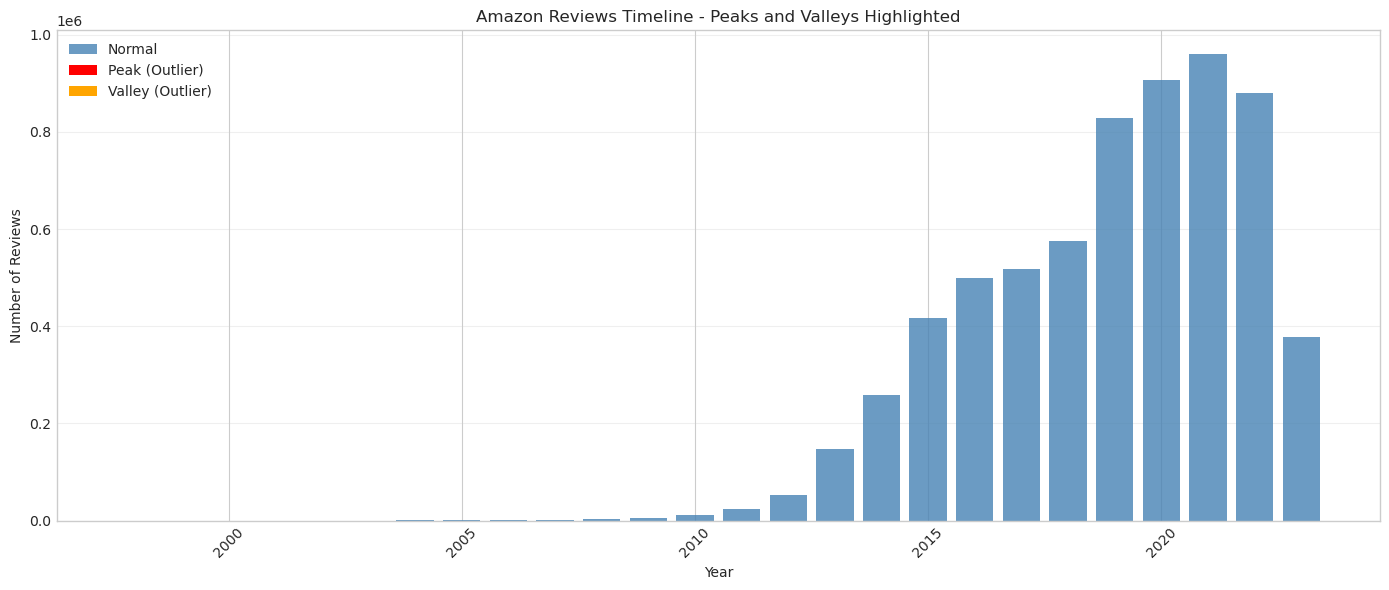

In [18]:
create_eda_timeline_plot(yearly_counts)

In [19]:
2+6*3

20